In [1]:
!nvidia-smi

Wed Sep 11 23:24:18 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0              45W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

## Required Imports and Device Setup

In [2]:
%pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 6.1 MB/s eta 0:00:00


In [3]:
from __future__ import print_function


import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter


from six.moves import xrange

import umap

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from tqdm import tqdm

import sys

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load Data

In [5]:
simple_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [6]:
transform = transforms.Compose([
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [7]:
# training_data = datasets.CIFAR10(root="data", train=True, download=True,
#                                   transform=transforms.Compose([
#                                       transforms.ToTensor(),
#                                       transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
#                                   ]))

# validation_data = datasets.CIFAR10(root="data", train=False, download=True,
#                                   transform=transforms.Compose([
#                                       transforms.ToTensor(),
#                                       transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
#                                   ]))

In [8]:
training_data = datasets.Flowers102(root="data", split="train", download=True,
                                    transform=transforms.Compose([
                                      transforms.RandomCrop(256),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
                                  ]))
validation_data = datasets.Flowers102(root="data", split="val", download=True,
                                      transform=transforms.Compose([
                                      transforms.CenterCrop(256),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
                                  ]))
testing_data = datasets.Flowers102(root="data", split="test", download=True,
                                   transform=transforms.Compose([
                                      transforms.CenterCrop(256),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
                                  ]))

100%|██████████| 344862509/344862509 [00:16<00:00, 20827145.38it/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 737234.11it/s]


100%|██████████| 14989/14989 [00:00<00:00, 18425680.73it/s]


In [9]:
# data = datasets.MNIST(root="data", train=True, download=True,
#                                   transform=transforms.Compose([
#                                       transforms.ToTensor(),
#                                       transforms.Normalize((0.5,), (1.0,))
#                                   ]))


# training_data, validation_data = torch.utils.data.random_split(data, [50000, 10000])

In [10]:
# training_data = datasets.CelebA("data", split="train", download=True, transform=transform)
# validation_data = datasets.CelebA("data", split="valid", download=True, transform=transform)
# testing_data = datasets.CelebA("data", split="test", download=True, transform=transform)

In [11]:
# size of the training data
len(training_data)

1020

In [12]:
display(training_data)

Dataset Flowers102
    Number of datapoints: 1020
    Root location: data
    split=train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(256, 256), padding=None)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(1.0, 1.0, 1.0))
           )

In [13]:
# universal experiment set-up

batch_size = 8
num_epochs = 500

num_channels = 3 # 1 for grayscale images 3 for RGB images
num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2

embedding_dim = 4
num_embeddings = 512

commitment_cost = 0.25

learning_rate = 1e-4

disc_start = int(0.8 * (len(training_data) / batch_size) * num_epochs) if num_epochs >= 5000 else sys.maxsize

log_interval = 100

debug = False

In [14]:
# define dataloaders
training_loader = DataLoader(training_data,
                             batch_size=batch_size,
                             shuffle=True,
                             pin_memory=True)

validation_loader = DataLoader(validation_data,
                               batch_size=32,
                               shuffle=False,
                               pin_memory=True)

In [15]:
# compute dataset variance
data_variance = 0.

for x, _ in training_loader:
    data_variance += x.var()
data_variance /= len(training_loader)

print(f'Dataset variance: {data_variance}')

Dataset variance: 0.08404450118541718


## VQ-VAE

Variational Auto Encoders (VAEs) can be thought of as what all but the last layer of a neural network is doing, namely feature extraction or seperating out the data. Thus given some data we can think of using a neural network for representation generation.

Recall that the goal of a generative model is to estimate the probability distribution of high dimensional data such as images, videos, audio or even text by learning the underlying structure in the data as well as the dependencies between the different elements of the data. This is very useful since we can then use this representation to generate new data with similar properties. This way we can also learn useful features from the data in an unsupervised fashion.

The VQ-VAE uses a discrete latent representation mostly because many important real-world objects are discrete. For example in images we might have categories like "Cat", "Car", etc. and it might not make sense to interpolate between these categories. Discrete representations are also easier to model since each category has a single value whereas if we had a continous latent space then we will need to normalize this density function and learn the dependencies between the different variables which could be very complex.

### Code

I have followed the code from the TensorFlow implementation by the author which you can find here [vqvae.py](https://github.com/deepmind/sonnet/blob/master/sonnet/python/modules/nets/vqvae.py) and [vqvae_example.ipynb](https://github.com/deepmind/sonnet/blob/master/sonnet/examples/vqvae_example.ipynb).

Another PyTorch implementation is found at [pytorch-vqvae](https://github.com/ritheshkumar95/pytorch-vqvae).


### Basic Idea

The overall architecture is summarized in the diagram below:

![](https://github.com/zalandoresearch/pytorch-vq-vae/blob/master/images/vq-vae.png?raw=1)

We start by defining a latent embedding space of dimension `[K, D]` where `K` are the number of embeddings and `D` is the dimensionality of each latent embeddng vector, i.e. $e_i \in \mathbb{R}^{D}$. The model is comprised of an encoder and a decoder. The encoder will map the input to a sequence of discrete latent variables, whereas the decoder will try to reconstruct the input from these latent sequences.

More preciesly, the model will take in batches of RGB images,  say $x$, each of size 32x32 for our example, and pass it through a ConvNet encoder producing some output $E(x)$, where we make sure the channels are the same as the dimensionality of the latent embedding vectors. To calculate the discrete latent variable we find the nearest embedding vector and output it's index.

The input to the decoder is the embedding vector corresponding to the index which is passed through the decoder to produce the reconstructed image.

Since the nearest neighbour lookup has no real gradient in the backward pass we simply pass the gradients from the decoder to the encoder  unaltered. The intuition is that since the output representation of the encoder and the input to the decoder share the same `D` channel dimensional space, the gradients contain useful information for how the encoder has to change its output to lower the reconstruction loss.

### Vector Quantizer Layer

This layer takes a tensor to be quantized. The channel dimension will be used as the space in which to quantize. All other dimensions will be flattened and will be seen as different examples to quantize.

The output tensor will have the same shape as the input.

As an example for a `BCHW` tensor of shape `[16, 64, 32, 32]`, we will first convert it to an `BHWC` tensor of shape `[16, 32, 32, 64]` and then reshape it into `[16384, 64]` and all `16384` vectors of size `64`  will be quantized independently. In otherwords, the channels are used as the space in which to quantize. All other dimensions will be flattened and be seen as different examples to quantize, `16384` in this case.

In [16]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()

        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings

        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape

        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)

        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))

        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)

        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss

        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

We will also implement a slightly modified version  which will use exponential moving averages to update the embedding vectors instead of an auxillary loss. This has the advantage that the embedding updates are independent of the choice of optimizer for the encoder, decoder and other parts of the architecture. For most experiments the EMA version trains faster than the non-EMA version.

In [17]:
class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()

        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings

        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.normal_()
        self._commitment_cost = commitment_cost

        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()

        self._decay = decay
        self._epsilon = epsilon

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape

        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)

        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))

        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)

        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)

            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n)

            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)

            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))

        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        loss = self._commitment_cost * e_latent_loss

        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

### Encoder & Decoder Architecture

The encoder and decoder architecture is based on a ResNet and is implemented below:

In [18]:
class Residual(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
        super(Residual, self).__init__()
        self._block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(in_channels=in_channels,
                      out_channels=num_residual_hiddens,
                      kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(in_channels=num_residual_hiddens,
                      out_channels=num_hiddens,
                      kernel_size=1, stride=1, bias=False)
        )

    def forward(self, x):
        return x + self._block(x)


class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(ResidualStack, self).__init__()
        self._num_residual_layers = num_residual_layers
        self._layers = nn.ModuleList([Residual(in_channels, num_hiddens, num_residual_hiddens)
                             for _ in range(self._num_residual_layers)])

    def forward(self, x):
        for i in range(self._num_residual_layers):
            x = self._layers[i](x)
        return F.relu(x)

In [19]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Encoder, self).__init__()

        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_2 = nn.Conv2d(in_channels=num_hiddens//2,
                                 out_channels=num_hiddens,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_3 = nn.Conv2d(in_channels=num_hiddens,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)

    def forward(self, inputs):
        x = self._conv_1(inputs)
        x = F.relu(x)

        x = self._conv_2(x)
        x = F.relu(x)

        x = self._conv_3(x)
        return self._residual_stack(x)

In [20]:
class Decoder(nn.Module):
    def __init__(self, in_channels, num_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Decoder, self).__init__()

        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)

        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)

        self._conv_trans_1 = nn.ConvTranspose2d(in_channels=num_hiddens,
                                                out_channels=num_hiddens//2,
                                                kernel_size=4,
                                                stride=2, padding=1)

        self._conv_trans_2 = nn.ConvTranspose2d(in_channels=num_hiddens//2,
                                                out_channels=num_channels,
                                                kernel_size=4,
                                                stride=2, padding=1)

    def forward(self, inputs):
        x = self._conv_1(inputs)

        x = self._residual_stack(x)

        x = self._conv_trans_1(x)
        x = F.relu(x)

        return self._conv_trans_2(x)

In [21]:
class Discriminator(nn.Module):
    def __init__(self, num_channels, num_filters_last=64, n_layers=3):
        super(Discriminator, self).__init__()

        layers = [nn.Conv2d(num_channels, num_filters_last, 4, 2, 1), nn.LeakyReLU(0.2)]
        num_filters_mult = 1

        for i in range(1, n_layers + 1):
            num_filters_mult_last = num_filters_mult
            num_filters_mult = min(2 ** i, 8)
            layers += [
                nn.Conv2d(num_filters_last * num_filters_mult_last, num_filters_last * num_filters_mult, 4,
                          2 if i < n_layers else 1, 1, bias=False),
                nn.BatchNorm2d(num_filters_last * num_filters_mult),
                nn.LeakyReLU(0.2, True)
            ]

        layers.append(nn.Conv2d(num_filters_last * num_filters_mult, 1, 4, 1, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

### Training Experiments

We use the hyperparameters from the author's code:

In [22]:
# hyperparameters

decay = 0.99

In [23]:
class VQGAN(nn.Module):
    def __init__(self, num_hiddens, num_channels, num_residual_layers, num_residual_hiddens,
                 num_embeddings, embedding_dim, commitment_cost, decay=0):
        super(VQGAN, self).__init__()

        self._encoder = Encoder(num_channels, num_hiddens,
                                num_residual_layers,
                                num_residual_hiddens)
        self._pre_vq_conv = nn.Conv2d(in_channels=num_hiddens,
                                      out_channels=embedding_dim,
                                      kernel_size=1,
                                      stride=1)
        if decay > 0.0:
            print(f'Performing EMA updates with decay rate: {decay}...')
            self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim,
                                              commitment_cost, decay)
        else:
            self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim,
                                           commitment_cost)
        self._decoder = Decoder(embedding_dim,
                                num_channels,
                                num_hiddens,
                                num_residual_layers,
                                num_residual_hiddens)

    def calculate_lambda(self, perceptual_loss, gan_loss, epsilon=1e-4, max_lambda=1e4, scale=0.8):
        '''Calculate the lambda value for the loss function.
        '''
        ell = self._decoder._conv_trans_2 # the last layer of the decoder
        ell_weight = ell.weight
        perceptual_loss_gradients = torch.autograd.grad(perceptual_loss, ell_weight, retain_graph=True)[0]
        gan_loss_gradients = torch.autograd.grad(gan_loss, ell_weight, retain_graph=True)[0]

        lambda_factor = torch.norm(perceptual_loss_gradients) / torch.norm(gan_loss_gradients + epsilon)
        lambda_factor = torch.clamp(lambda_factor, min=0.0, max=max_lambda).detach()

        return scale * lambda_factor

    def forward(self, x):
        z = self._encoder(x)
        z = self._pre_vq_conv(z)
        loss, quantized, perplexity, _ = self._vq_vae(z)
        x_recon = self._decoder(quantized)

        return loss, x_recon, perplexity, z

In [24]:
def init_weights(m):
    """Initialize the weights of the module.

    Args:
        m (nn.Module): Module to initialize the weights of.
    """
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [25]:
discriminator = Discriminator(num_channels=num_channels).to(device)
discriminator.apply(init_weights)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

In [39]:
vqgan = VQGAN(num_hiddens, num_channels, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim,
              commitment_cost, decay).to(device)

vqgan_optim = optim.Adam(vqgan.parameters(), lr=learning_rate, amsgrad=False)
opt_disc = optim.Adam(discriminator.parameters(), lr=learning_rate, amsgrad=False)

print('='*50)
print('Model Summary:')
print(vqgan.eval())
print('-'*50)
print('Experiment Settings:')
print(f'- Number of epochs: {num_epochs}')
print(f'- Learning rate: {learning_rate}')
print(f'- Batch size: {batch_size}')
print(f'- Commitment cost: {commitment_cost}')
print(f'- Number of Embeddings: {num_embeddings}')
print(f'- Embedding dimension: {embedding_dim}')
print('='*50)

vqgan.train()
train_res_recon_error = []
train_res_perplexity = []
train_res_vq_loss = []
train_res_gan_loss = []
train_res_psnr = []
disc_factor = 0.

global_step = 0

for epoch in range(num_epochs):
  with tqdm(training_loader, unit="batch") as pbar:
      for data, _ in pbar:
        data = data.to(device)
        vqgan_optim.zero_grad()

        vq_loss, data_recon, perplexity, latents = vqgan(data)

        recon_error = F.mse_loss(data_recon, data) / data_variance
        loss = recon_error + vq_loss

        opt_disc.zero_grad()

        disc_real = discriminator(data)
        disc_fake = discriminator(data_recon)

        disc_loss_real = torch.mean(F.relu(1. - disc_real))
        disc_loss_fake = torch.mean(F.relu(1. + disc_fake))

        if global_step > disc_start:
          disc_factor = 0.2

        g_loss = -torch.mean(disc_fake)

        loss += disc_factor * vqgan.calculate_lambda(recon_error, g_loss) * g_loss

        loss.backward(retain_graph=True)

        gan_loss = disc_factor * 0.5 * (disc_loss_real + disc_loss_fake)

        gan_loss.backward()

        vqgan_optim.step()
        opt_disc.step()

        # compute PSNR
        psnr = 10 * torch.log10(1 / recon_error)

        train_res_recon_error.append(recon_error.item())
        train_res_perplexity.append(perplexity.item())
        train_res_vq_loss.append(vq_loss.item())
        train_res_gan_loss.append(gan_loss.item())
        train_res_psnr.append(psnr.item())

        pbar.set_description(f"Epoch {epoch + 1}/{num_epochs}")

        pbar.set_postfix(recon_error=np.mean(train_res_recon_error[-100:]),
                          perplexity=np.mean(train_res_perplexity[-100:]),
                          vq_loss=np.mean(train_res_vq_loss[-100:]),
                          gan_loss=np.mean(train_res_gan_loss[-100:]),
                          psnr=np.mean(train_res_psnr[-100:]))

        global_step += 1

Performing EMA updates with decay rate: 0.99...
Model Summary:
VQGAN(
  (_encoder): Encoder(
    (_conv_1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (_conv_2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (_conv_3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (_residual_stack): ResidualStack(
      (_layers): ModuleList(
        (0-1): 2 x Residual(
          (_block): Sequential(
            (0): ReLU(inplace=True)
            (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (2): ReLU(inplace=True)
            (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          )
        )
      )
    )
  )
  (_pre_vq_conv): Conv2d(128, 4, kernel_size=(1, 1), stride=(1, 1))
  (_vq_vae): VectorQuantizerEMA(
    (_embedding): Embedding(512, 4)
  )
  (_decoder): Decoder(
    (_conv_1): Conv2d(4, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 

Epoch 500/500: 100%|██████████| 128/128 [00:06<00:00, 18.73batch/s, gan_loss=0, perplexity=289, psnr=21.3, recon_error=0.0078, vq_loss=0.00205]


In [41]:
# save model
torch.save(vqgan.state_dict(), 'vqgan-ldm.pt')

In [42]:
sum(p.numel() for p in vqgan._encoder.parameters())

363840

In [56]:
%pip install diffusers["torch"] transformers

In [57]:
%pip install accelerate

In [58]:
from diffusers import DDPMScheduler, UNet2DModel

scheduler = DDPMScheduler.from_pretrained("google/ddpm-cat-256")
model = UNet2DModel.from_pretrained("google/ddpm-cat-256", use_safetensors=True).to("cuda")

In [59]:
scheduler.set_timesteps(100)

In [60]:
scheduler.timesteps

tensor([990, 980, 970, 960, 950, 940, 930, 920, 910, 900, 890, 880, 870, 860,
        850, 840, 830, 820, 810, 800, 790, 780, 770, 760, 750, 740, 730, 720,
        710, 700, 690, 680, 670, 660, 650, 640, 630, 620, 610, 600, 590, 580,
        570, 560, 550, 540, 530, 520, 510, 500, 490, 480, 470, 460, 450, 440,
        430, 420, 410, 400, 390, 380, 370, 360, 350, 340, 330, 320, 310, 300,
        290, 280, 270, 260, 250, 240, 230, 220, 210, 200, 190, 180, 170, 160,
        150, 140, 130, 120, 110, 100,  90,  80,  70,  60,  50,  40,  30,  20,
         10,   0])

In [61]:
sample_size = model.config.sample_size
noise = torch.randn((1, 3, sample_size, sample_size), device="cuda")

In [62]:
input = noise

for t in scheduler.timesteps:
    with torch.no_grad():
        noisy_residual = model(input, t).sample
    previous_noisy_sample = scheduler.step(noisy_residual, t, input).prev_sample
    input = previous_noisy_sample

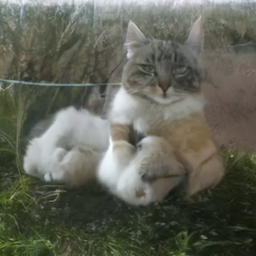

In [63]:
from PIL import Image
import numpy as np

image = (input / 2 + 0.5).clamp(0, 1).squeeze()
image = (image.permute(1, 2, 0) * 255).round().to(torch.uint8).cpu().numpy()
image = Image.fromarray(image)
image

In [64]:
torch_device = "cuda"

In [65]:
from PIL import Image
import torch
from transformers import utils, CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", use_safetensors=True)
# vqgan = VQGAN(num_hiddens, num_channels, num_residual_layers, num_residual_hiddens,
#               num_embeddings, embedding_dim,
#               commitment_cost, decay).to(device)
# vqgan.load_state_dict(torch.load('vqgan-ldm.pt', weights_only=False))
tokenizer = CLIPTokenizer.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="tokenizer");
tokenizer.clean_up_tokenization_spaces = True
text_encoder = CLIPTextModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder="text_encoder", use_safetensors=True
)
unet = UNet2DConditionModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder="unet", use_safetensors=True
)

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

In [66]:
from diffusers import UniPCMultistepScheduler
from tqdm.auto import tqdm

scheduler = UniPCMultistepScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

In [67]:
vae.to(torch_device)
text_encoder.to(torch_device)
unet.to(torch_device)

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_fe

In [315]:
prompt = ["cyberpunk boxer fighting a kangaroo"]
height = 512  # default height of Stable Diffusion
width = 512  # default width of Stable Diffusion
num_inference_steps = 100  # Number of denoising steps
guidance_scale = 7.5  # Scale for classifier-free guidance
generator = torch.cuda.manual_seed(0)  # Seed generator to create the initial latent noise
batch_size = len(prompt)

In [316]:
text_input = tokenizer(
    prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt"
)

with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

In [317]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

In [318]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

In [319]:
latents = torch.randn(
    (batch_size, unet.config.in_channels, height // 8, width // 8),
    generator=generator,
    device=torch_device,
)

In [320]:
latents = latents * scheduler.init_noise_sigma

In [321]:
scheduler.set_timesteps(num_inference_steps)

for t in tqdm(scheduler.timesteps):
      # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
      latent_model_input = torch.cat([latents] * 2)

      latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

      # predict the noise residual
      with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

      # perform guidance
      noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
      noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

      # compute the previous noisy sample x_t -> x_t-1
      latents = scheduler.step(noise_pred, t, latents).prev_sample

  0%|          | 0/100 [00:00<?, ?it/s]

In [322]:
# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents

In [323]:
print(latents.shape)

torch.Size([1, 4, 64, 64])


In [324]:
with torch.no_grad():
  target = vae.decode(latents).sample

In [325]:
vqgan = VQGAN(num_hiddens, num_channels, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim,
              commitment_cost, decay).to(device)
vqgan.load_state_dict(torch.load('vqgan-ldm.pt', weights_only=False))

Performing EMA updates with decay rate: 0.99...


<All keys matched successfully>

In [326]:
vqgan_optim = optim.Adam(vqgan.parameters(), lr=learning_rate, amsgrad=False)

In [327]:
for i in range(1000):
  vqgan_optim.zero_grad()

  _, quantized, _, _ = vqgan._vq_vae(latents)
  image = vae.decode(quantized).sample

  loss = F.mse_loss(target, image)
  loss.backward()
  vqgan_optim.step()

  if i % 100 == 0:
    print(f'Iteration {i}: {loss.item()}')

Iteration 0: 0.45285338163375854
Iteration 100: 0.04589604586362839
Iteration 200: 0.04159344732761383
Iteration 300: 0.04040749743580818
Iteration 400: 0.03954029455780983
Iteration 500: 0.03875768184661865
Iteration 600: 0.037619493901729584
Iteration 700: 0.03693724051117897
Iteration 800: 0.03548023849725723
Iteration 900: 0.033251021057367325


In [302]:
with torch.no_grad():
  _, quantized, _, _ = vqgan._vq_vae(latents)
  image = vae.decode(quantized).sample

In [303]:
# compute PSNR
psnr = 10 * torch.log10(1 / F.mse_loss(image, target))
psnr

tensor(15.8818, device='cuda:0')

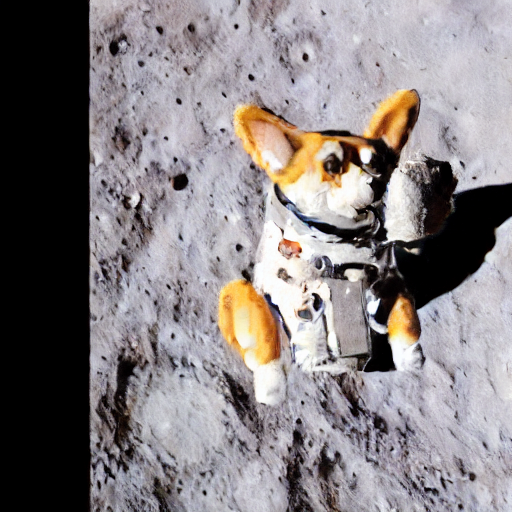

In [304]:
image = (image / 2 + 0.5).clamp(0, 1).squeeze()
image = (image.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
image = Image.fromarray(image)
image

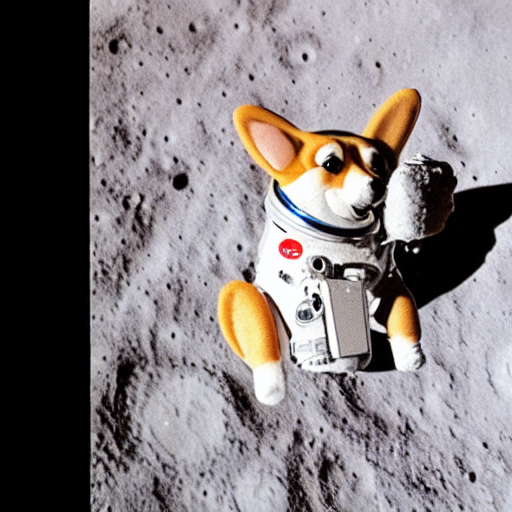

In [305]:
target = (target / 2 + 0.5).clamp(0, 1).squeeze()
target = (target.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
target = Image.fromarray(target)
target

## DL-GAN

### Dictionary Learning Bottleneck

In [43]:
class DictLearn(nn.Module):
    """
    Dictionary Learning.

    See:
    - M. Aharon, M. Elad, and A. Bruckstein, "K-SVD: An Algorithm for Designing Overcomplete Dictionaries for Sparse Representation," IEEE Trans. Signal Processing, vol. 54, no. 11, pp. 4311-4322, 2006.
    - Rubinstein, R., Zibulevsky, M. and Elad, M., "Efficient Implementation of the K-SVD Algorithm using Batch Orthogonal Matching Pursuit," CS Technion, 2008.
    """
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, sparsity_level):
        """
        class constructor for DictLearn

        :param embedding_dim: dimension of the embedding
        :param num_embeddings: number of dictionary atoms
        :param sparsity_level: maximum sparsity (number of non-zero coefficients) of the representation, reduces to K-Means (Vector Quantization) when set to 1
        :param initial_dict: initial dictionary if given, otherwise random rows from the data matrix are used
        :param max_iter: maximum number of iterations
        """
        super(DictLearn, self).__init__()

        self._num_embeddings = num_embeddings
        self._embedding_dim = embedding_dim
        self._commitment_cost = commitment_cost
        self._sparsity_level = sparsity_level

        self._dictionary = nn.Embedding(embedding_dim, num_embeddings)
        self._dictionary.weight.data.normal_(0, 1)
        self._dictionary.weight.data.copy_(self._dictionary.weight / torch.linalg.norm(self._dictionary.weight, dim=0))

        self._gamma = None
        self._A = None
        self._B = None

    def forward(self, z_e):
        if z_e.shape[2] * z_e.shape[3] < self._num_embeddings:
            kernel_size = z_e.shape[2]
        else:
            kernel_size = 8

        stride = kernel_size # non-overlapping patches

        # break the input tensor into patches
        patches = F.unfold(z_e, kernel_size=kernel_size, stride=stride).permute(2, 0, 1).contiguous()
        patches_shape = patches.shape
        patches = patches.view(patches.shape[0] * patches.shape[1], self._embedding_dim, kernel_size, kernel_size).contiguous()

        # permute
        z_e = z_e.permute(0, 2, 3, 1).contiguous()
        ze_shape = z_e.shape
        # Flatten input
        ze_flattened = z_e.view(self._embedding_dim, -1).contiguous() # convert to column-major order, i.e., each column is a data point

        # flatten patches
        patches = patches.view(self._embedding_dim, -1).contiguous()

        """
        Sparse Coding Stage
        """

        if self._gamma is None:
          # initialize dictionary with random columns of z_e
          # self._dictionary.weight.data.copy_(nn.Parameter(z_e[:, torch.randperm(z_e.shape[1])[:self._num_embeddings]]))
          # normalize the dictionary
          self._dictionary.weight.data.copy_(nn.Parameter(self._dictionary.weight / torch.linalg.norm(self._dictionary.weight, dim=0)))
          # initialize the sparse codes
          self._gamma = nn.Parameter(self.update_gamma(patches.detach(), self._dictionary.weight.detach(), debug=False))
        else:
          # normalize dictionary
          self._dictionary.weight.data.copy_(nn.Parameter(self._dictionary.weight / torch.linalg.norm(self._dictionary.weight, dim=0)))
          # update the sparse codes
          self._gamma.data.copy_(self.update_gamma(patches.detach(), self._dictionary.weight.detach(), debug=False))

        encodings = self._gamma.detach() # sparse codes

        # compute reconstruction
        recon = self._dictionary.weight @ self._gamma.detach()
        recon = recon.view(patches_shape).permute(1, 2, 0).contiguous() # convert to patches

        # fold back the patches
        recon = F.fold(recon, (ze_shape[1], ze_shape[2]), kernel_size=kernel_size, stride=stride).permute(0, 2, 3, 1).contiguous()

        # compute loss
        e_latent_loss = F.mse_loss(recon.detach(), z_e) * self._commitment_cost # latent loss from encoder
        loss = e_latent_loss + F.mse_loss(recon, z_e.detach()) # reconstruction loss

        # straight-through gradient estimator
        recon = z_e + (recon - z_e).detach()

        # compute perplexity
        avg_probs = torch.mean(encodings.bool().float() / self._sparsity_level, dim=1) # convert nonzero entries of encodings to 1.0
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        return loss, e_latent_loss, recon.permute(0, 3, 1, 2).contiguous(), z_e.detach(), perplexity, encodings

    def update_dictionary(self, z_e, dictionary, t):
        """online dictionary update via Block Coordinate Descent.

        References:
        - Mairal J, Bach F, Ponce J, Sapiro G. Online dictionary learning for sparse coding.
          In Proceedings of the 26th annual international conference on machine learning 2009 Jun 14 (pp. 689-696).
        """
        # # compute beta
        # theta = 0
        # eta = z_e.shape[1]

        # if t < eta:
        #   theta = t * eta
        # else:
        #   theta = eta ** 2 + t - eta

        # beta = (theta + 1 - eta) / (theta + 1)

        # # precomputations
        # if self._A is None:
        #   self._A = self._gamma.mm(self._gamma.t()) + torch.diag(torch.ones(self._num_embeddings, device='cuda')) * 1e-10
        # else:
        #   self._A = nn.Parameter(beta * self._A + self._gamma.mm(self._gamma.t()) + torch.diag(torch.ones(self._num_embeddings, device='cuda')) * 1e-10)
        # if self._B is None:
        #   self._B = z_e.mm(self._gamma.t()) + torch.diag(torch.ones(self._embedding_dim, device='cuda')) * 1e-10
        # else:
        #   self._B = nn.Parameter(beta * self._B + z_e.mm(self._gamma.t()) + torch.diag(torch.ones(self._embedding_dim, device='cuda')) * 1e-10)

        # self._dictionary.weight.data.copy_((self._B - self._dictionary.weight @ self._A) / self._A.diag() + self._dictionary.weight)
        # self._dictionary.weight.data.copy_(self._dictionary.weight / torch.linalg.norm(self._dictionary.weight, dim=0))

        # self._dictionary.weight.data.copy_(
        #     self._dictionary.weight - (self._eta / z_e.shape[1]) * (self._dictionary.weight @ self._gamma - z_e) @ torch.sign(self._gamma).t())
        # self._dictionary.weight.data.copy_(self._dictionary.weight / torch.linalg.norm(self._dictionary.weight, dim=0))

    def update_gamma(self, signals, dictionary, debug=False):
        """sparse coding stage

        Implemented using the Batch Orthogonal Matching Pursuit (OMP) algorithm.

        Reference:
        - Rubinstein, R., Zibulevsky, M. and Elad, M., "Efficient Implementation of the K-SVD Algorithm using Batch Orthogonal Matching Pursuit," CS Technion, 2008.

        :param signals: input signals to be sparsely coded
        """
        embedding_dim, num_signals = signals.shape
        dictionary_t = dictionary.t() # save the transpose of the dictionary for faster computation
        gram_matrix = dictionary_t.mm(dictionary) # the Gram matrix, dimension: num_atoms x num_atoms
        eps = torch.norm(signals, dim=0) # residual, initialized as the L2 norm of the signal
        corr_init = dictionary_t.mm(signals).t() # initial correlation vector, transposed to make num_signals the first dimension
        gamma = torch.zeros_like(corr_init) # placeholder for the sparse coefficients

        corr = corr_init
        L = torch.ones(num_signals, 1, 1, device=signals.device) # contains the progressive Cholesky of the Gram matrix in the selected indices
        I = torch.zeros(num_signals, 0, dtype=torch.long, device=signals.device) # placeholder for the index set
        omega = torch.ones_like(corr_init, dtype=torch.bool) # used to zero out elements in corr before argmax
        signal_idx = torch.arange(num_signals, device=signals.device)
        delta = torch.zeros(num_signals, device=signals.device) # to track residuals

        k = 0
        while k < self._sparsity_level:
            k += 1
            k_hats = torch.argmax(torch.abs(corr * omega), dim=1) # select the index of the maximum correlation
            # update omega to make sure we do not select the same index twice
            omega[torch.arange(k_hats.shape[0], device=signals.device), k_hats] = 0
            expanded_signal_idx = signal_idx.unsqueeze(0).expand(k, num_signals).t() # expand is more efficient than repeat

            if k > 1: # Cholesky update
                G_ = gram_matrix[I[signal_idx, :], k_hats[expanded_signal_idx[...,:-1]]].view(num_signals, k - 1, 1) # compute for all signals in a vectorized manner
                w = torch.linalg.solve_triangular(L, G_, upper=False).view(-1, 1, k - 1)
                w_br = torch.sqrt(1 - (w**2).sum(dim=2, keepdim=True)) # L bottom-right corner element: sqrt(1 - w.t().mm(w))

                # concatenate into the new Cholesky: L <- [[L, 0], [w, w_br]]
                k_zeros = torch.zeros(num_signals, k - 1, 1, device=signals.device)
                L = torch.cat((
                    torch.cat((L, k_zeros), dim=2),
                    torch.cat((w, w_br), dim=2),
                    ), dim=1)

            # update non-zero indices
            I = torch.cat([I, k_hats.unsqueeze(1)], dim=1)

            # solve L
            corr_ = corr_init[expanded_signal_idx, I[signal_idx, :]].view(num_signals, k, 1)
            gamma_ = torch.cholesky_solve(corr_, L)

            # de-stack gamma into the non-zero elements
            gamma[signal_idx.unsqueeze(1), I[signal_idx]] = gamma_[signal_idx].squeeze(-1)

            # beta = G_I * gamma_I
            beta = gamma[signal_idx.unsqueeze(1), I[signal_idx]].unsqueeze(1).bmm(gram_matrix[I[signal_idx], :]).squeeze(1)

            corr = corr_init - beta

            # update residual
            # new_delta = (gamma * beta).sum(dim=1)
            # eps += delta-new_delta
            # delta = new_delta

            if debug and k % 1 == 0:
              print('Step {}, residual: {:.4f}, below tolerance: {:.4f}'.format(k, eps.max(), (eps < 1e-7).float().mean().item()))

        return gamma.t() # transpose the sparse coefficients to make num_signals the first dimension

### Define the Model DL-GAN

In [44]:
class DLGAN(nn.Module):
    def __init__(self, num_hiddens, num_channels, num_residual_layers, num_residual_hiddens,
                 num_embeddings, embedding_dim, commitment_cost, sparsity_level):
        super(DLGAN, self).__init__()

        self._encoder = Encoder(num_channels, num_hiddens,
                                num_residual_layers,
                                num_residual_hiddens)

        self._pre_vq_conv = nn.Conv2d(in_channels=num_hiddens,
                                      out_channels=embedding_dim,
                                      kernel_size=1,
                                      stride=1)

        self._dl_bottleneck = DictLearn(num_embeddings,
                                     embedding_dim,
                                     commitment_cost=commitment_cost,
                                     sparsity_level=sparsity_level)

        self._decoder = Decoder(embedding_dim,
                                num_channels,
                                num_hiddens,
                                num_residual_layers,
                                num_residual_hiddens)

    def forward(self, x, global_step):
        z = self._encoder(x)
        z = self._pre_vq_conv(z)
        loss, dl_loss, sparsified, latents, perplexity, encodings = self._dl_bottleneck(z)
        # self._dl_bottleneck.update_dictionary(latents.detach(), self._dl_bottleneck._dictionary.weight, global_step)
        x_recon = self._decoder(sparsified)

        return loss, dl_loss, x_recon, latents, perplexity, encodings

    def calculate_lambda(self, perceptual_loss, gan_loss, epsilon=1e-4, max_lambda=1e4, scale=0.8):
        '''Calculate the lambda value for the loss function.
        '''
        ell = self._decoder._conv_trans_2 # the last layer of the decoder
        ell_weight = ell.weight
        perceptual_loss_gradients = torch.autograd.grad(perceptual_loss, ell_weight, retain_graph=True)[0]
        gan_loss_gradients = torch.autograd.grad(gan_loss, ell_weight, retain_graph=True)[0]

        lambda_factor = torch.norm(perceptual_loss_gradients) / torch.norm(gan_loss_gradients + epsilon)
        lambda_factor = torch.clamp(lambda_factor, min=0.0, max=max_lambda).detach()

        return scale * lambda_factor

In [45]:
dl_disc = Discriminator(num_channels).to(device)
dl_disc.apply(init_weights)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

### Training Experiments

In [46]:
# hyperparameters

sparsity_level = 3

In [47]:
dlgan_model = DLGAN(num_hiddens, num_channels, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim,
              commitment_cost, sparsity_level).to(device)

In [48]:
dlgan_model.eval()

DLGAN(
  (_encoder): Encoder(
    (_conv_1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (_conv_2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (_conv_3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (_residual_stack): ResidualStack(
      (_layers): ModuleList(
        (0-1): 2 x Residual(
          (_block): Sequential(
            (0): ReLU(inplace=True)
            (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (2): ReLU(inplace=True)
            (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          )
        )
      )
    )
  )
  (_pre_vq_conv): Conv2d(128, 4, kernel_size=(1, 1), stride=(1, 1))
  (_dl_bottleneck): DictLearn(
    (_dictionary): Embedding(4, 512)
  )
  (_decoder): Decoder(
    (_conv_1): Conv2d(4, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (_residual_stack): ResidualStack(
      (_layers): ModuleList

In [50]:
# optimizer setup
dlgan_optim = optim.Adam(dlgan_model.parameters(), lr=learning_rate, amsgrad=False)
opt_disc = optim.Adam(dl_disc.parameters(), lr=learning_rate, amsgrad=False)

In [51]:
dlgan_model.train()

print('='*50)
print('Experiment Settings:')
print(f'- Number of epochs: {num_epochs}')
print(f'- Learning rate: {learning_rate}')
print(f'- Batch size: {batch_size}')
print(f'- Sparsity level: {sparsity_level}')
print(f'- Commitment cost: {commitment_cost}')
print(f'- Number of Embeddings: {num_embeddings}')
print(f'- Embedding dimension: {embedding_dim}')
print('='*50)
train_res_recon_error = []
train_res_perplexity = []
train_res_dl_loss = []
train_res_gan_loss = []
train_res_psnr = []
disc_factor = 0.

global_step = 0

for epoch in range(num_epochs):
  with tqdm(training_loader, unit="batch") as pbar:
    for i, (data, _) in enumerate(pbar):
      (data, _) = next(iter(training_loader))
      data = data.to(device)
      dlgan_optim.zero_grad()

      sc_loss, dl_loss, data_recon, latents, perplexity, encodings = dlgan_model(data, global_step)

      if debug:
        print(f'DEBUG: sparsity check: {torch.count_nonzero(encodings, dim=0)}')

      recon_error = F.mse_loss(data_recon, data) / data_variance

      loss = sc_loss + recon_error

      opt_disc.zero_grad()

      disc_real = discriminator(data)
      disc_fake = discriminator(data_recon)

      disc_loss_real = torch.mean(F.relu(1. - disc_real))
      disc_loss_fake = torch.mean(F.relu(1. + disc_fake))

      if global_step > disc_start:
        disc_factor = 0.2

      g_loss = -torch.mean(disc_fake)

      loss += disc_factor * dlgan_model.calculate_lambda(recon_error, g_loss) * g_loss

      loss.backward(retain_graph=True)

      gan_loss = disc_factor * 0.5 * (disc_loss_real + disc_loss_fake)

      gan_loss.backward()

      dlgan_optim.step()
      opt_disc.step()

      # compute PSNR
      psnr = 10 * torch.log10(1 / recon_error)

      train_res_recon_error.append(recon_error.item())
      train_res_perplexity.append(perplexity.item())
      train_res_dl_loss.append(dl_loss.item())
      train_res_gan_loss.append(gan_loss.item())
      train_res_psnr.append(psnr.item())

      global_step += 1

      pbar.set_description(f"Epoch {epoch + 1}/{num_epochs}")

      pbar.set_postfix(recon_error=np.mean(train_res_recon_error[-100:]),
                       perplexity=np.mean(train_res_perplexity[-100:]),
                       dl_loss=np.mean(train_res_dl_loss[-100:]),
                       gan_loss=np.mean(train_res_gan_loss[-100:]),
                       psnr=np.mean(train_res_psnr[-100:]))

Experiment Settings:
- Number of epochs: 500
- Learning rate: 0.0001
- Batch size: 8
- Sparsity level: 3
- Commitment cost: 0.25
- Number of Embeddings: 512
- Embedding dimension: 4


Epoch 500/500: 100%|██████████| 128/128 [00:10<00:00, 12.11batch/s, dl_loss=1.88e-8, gan_loss=0, perplexity=423, psnr=24.5, recon_error=0.00393]


In [53]:
# save model
torch.save(dlgan_model.state_dict(), 'dlgan-ldm.pt')

In [54]:
sum(p.numel() for p in dlgan_model._encoder.parameters())

363840

In [118]:
dlgan_optim = optim.Adam(dlgan_model.parameters(), lr=1e-4)

In [306]:
input = latents

In [307]:
input.shape

torch.Size([1, 4, 64, 64])

In [308]:
# preprocess the input
input = input.permute(0, 2, 3, 1).contiguous()
print(input.shape)
input = input.view(embedding_dim, -1).contiguous()

torch.Size([1, 64, 64, 4])


In [309]:
print(input.shape)

torch.Size([4, 4096])


In [135]:
dlgan_model.train()

for i in range(100):
  dlgan_optim.zero_grad()

  # normalize the dictionary
  dictionary = dlgan_model._dl_bottleneck._dictionary.weight.data / torch.linalg.norm(dlgan_model._dl_bottleneck._dictionary.weight.data, dim=0)
  sc = dlgan_model._dl_bottleneck.update_gamma(input, dictionary, debug=False)
  # reconstruct the latent space
  sparsified = dictionary @ sc
  sparsified = sparsified.view(1, 64, 64, 4).permute(0, 3, 1, 2).contiguous()
  image = vae.decode(sparsified).sample

  loss = F.mse_loss(target, image)
  loss.backward()
  dlgan_optim.step()

  if i % 100 == 0:
    print(f'Iteration {i}: {loss.item()}')

Iteration 0: 1.5613717323503806e-06


In [310]:
with torch.no_grad():
  target = vae.decode(latents).sample

In [311]:
with torch.no_grad():
  # normalize the dictionary
  dictionary = dlgan_model._dl_bottleneck._dictionary.weight.data / torch.linalg.norm(dlgan_model._dl_bottleneck._dictionary.weight.data, dim=0)
  sc = dlgan_model._dl_bottleneck.update_gamma(input, dictionary, debug=False)
  # reconstruct the latent space
  sparsified = dictionary @ sc
  sparsified = sparsified.view(1, 64, 64, 4).permute(0, 3, 1, 2).contiguous()
  image = vae.decode(sparsified).sample

In [312]:
# compute psnr
psnr = 10 * torch.log10(1 / F.mse_loss(target, image))
psnr

tensor(61.9399, device='cuda:0')

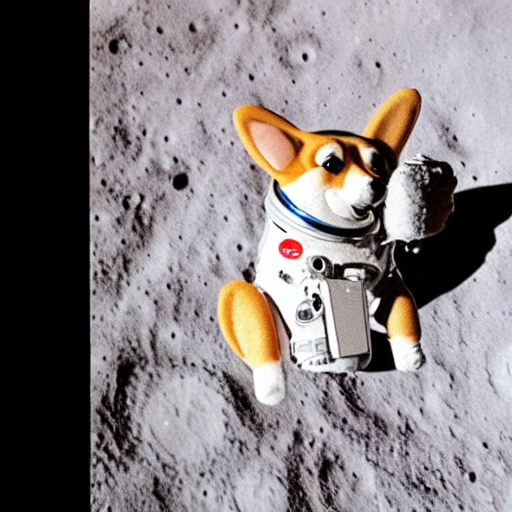

In [313]:
image = (image / 2 + 0.5).clamp(0, 1).squeeze()
image = (image.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
image = Image.fromarray(image)
image

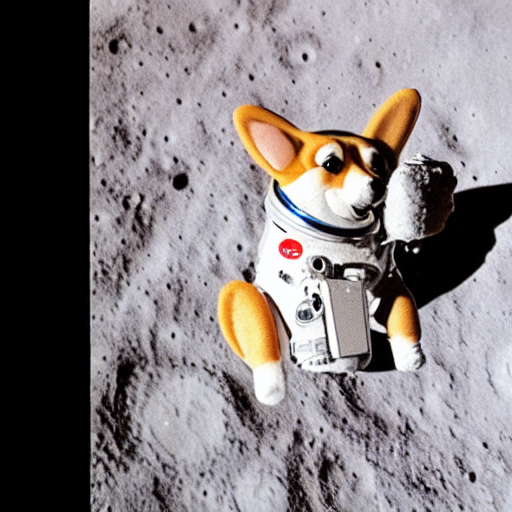

In [314]:
target = (target / 2 + 0.5).clamp(0, 1).squeeze()
target = (target.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
target = Image.fromarray(target)
target